In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sa

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    

load_dotenv()

True

In [2]:
from keras.models import load_model

model_view = load_model('../model/c-view.keras')
model_cart = load_model('../model/c-cart.keras')
model_purchase = load_model('../model/c-purchase.keras')

In [3]:
conn_string = 'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/cosmetic'.format(
    db_user=os.getenv('DB_USER'),
    db_password=os.getenv('DB_PASSWORD'),
    db_host=os.getenv('DB_HOST'),
    db_port=os.getenv('DB_PORT'),
)
engine = sa.create_engine(conn_string)

In [4]:
import datetime

start = datetime.date(2020, 2, 15)
end = datetime.date(2020, 3, 1)

sorts = 2

In [5]:
from collections import defaultdict
from math import log
from statistics import fmean
from sqlalchemy import orm
import random

from schemas.product import Product
from schemas.data_by_date import DataByDate
from utils.utils import date_range, data_descale, preprocess_c

def predict_future(s = 0):
    prev_days = int(os.getenv('PREV_DAYS'))

    with orm.Session(engine) as session, session.begin():
        products = dict[tuple[int, int], Product]()
        for row in session.scalars(sa.select(Product)).all():
            products[(row.product_id, row.category_id)] = row
        
        memorized = defaultdict(lambda: defaultdict(lambda: { 'view': 0, 'cart': 0, 'remove_from_cart': 0, 'purchase': 0 }))

        d = start - datetime.timedelta(days=max(30, prev_days))
        for i in range(max(30, prev_days)):
            for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
                key = (row.product_id, row.category_id)
                memorized[d][key] = {
                    'view': row.view,
                    'cart': row.cart,
                    'purchase': row.purchase,
                }

            d += datetime.timedelta(days=1)
        
        while d < end:
            print(d)
            records = list[dict]()

            rows = list[dict]()
            categories = defaultdict(lambda: list[dict]())
            for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
                key = (row.product_id, row.category_id)
                record = {
                    'product_id': row.product_id,
                    'category_id': row.category_id,
                    'old_rank_in_category': row.rank_in_category,
                    'view': row.view,
                    'cart': row.cart,
                    'purchase': row.purchase,
                    'rank_in_category': 0,
                    'days_on_shelf': (d - products[key].release_date).days,
                    'price': row.max_price,
                }

                rows.append(record)
                categories[row.category_id].append(record)

            def key_func0(record: dict):
                key = (record['product_id'], record['category_id'])
                prev_sales = sum(memorized[p][key]['purchase'] for p in date_range(d - datetime.timedelta(days=30), d, datetime.timedelta(days=1)))
                return -prev_sales, record['days_on_shelf'], record['price']
            
            intervals = [[1, 8], [8, 15], [15, 31]]
            weights = {
                'view': [0.8, 0.6, 0.2],
                'purchase': [1.2, 0.75, 0.75],
            }
            avgs = dict[str, float]()            
            def key_func1(record: dict):
                key = (record['product_id'], record['category_id'])
                acc = defaultdict(float)
                for f in ['view', 'purchase']:
                    for i in range(len(intervals)):
                        avg_f = fmean([memorized[d - datetime.timedelta(days=n)][key][f] for n in range(*intervals[i])])
                        acc[f] += avg_f / avgs[f'{f}{i}'] * weights[f][i]
                        if acc[f] < 0:
                            print(acc[f], avg_f)
                try:
                    popular_score = 1.1 * log(1 + acc['view']) + 0.81 * log(1 + acc['purchase']) + 1.65 * log(1 + avgs['recency'] / (record['days_on_shelf'] + 1))
                except:
                    print(acc)
                return -popular_score, record['days_on_shelf'], record['price']

            key_func = [key_func0, key_func1]
            for category in categories.values():
                if s == 1:
                    for f in ['view', 'purchase']:
                        for i in range(len(intervals)):
                            avg_f = fmean([memorized[d - datetime.timedelta(days=n)][(record['product_id'], record['category_id'])][f] for record in category for n in range(*intervals[i])])
                            avgs[f'{f}{i}'] = max(avg_f, 1)
                    avgs['recency'] = fmean([record['days_on_shelf'] + 1 for record in category])
                category.sort(key=key_func[s])
                for index, record in enumerate(category):
                    record['rank_in_category'] = index + 1
            
            for index, record in enumerate(rows):
                key = (record['product_id'], record['category_id'])

                for i in range(1, prev_days + 1):
                    prev_d = d - datetime.timedelta(days=i)
                    record[f'view_prev{i}'] = memorized[prev_d][key]['view']
                    record[f'cart_prev{i}'] = memorized[prev_d][key]['cart']
                    record[f'purchase_prev{i}'] = memorized[prev_d][key]['purchase']

                if (d - products[key].release_date).days >= 7:
                    records.append(record)
                else:
                    memorized[d][key] = {
                        'view': record['view'],
                        'cart': record['cart'],
                        'purchase': record['purchase'],
                    }
            
            del memorized[d - datetime.timedelta(days=max(30, prev_days))]

            df = pd.DataFrame.from_records(records)
            result_df = df.loc[:,[
                'product_id', 
                'category_id',
                'old_rank_in_category',
                'rank_in_category',
                'view', 
                'cart', 
                'purchase', 
            ]]
            df = df.drop(columns=['product_id', 'category_id', 'old_rank_in_category'])
            X1, X2, y = preprocess_c(df)
            result_df['predicted_view'] = data_descale(model_view.predict([X1, X2])[:, 0], 'view')
            result_df['predicted_cart'] = data_descale(model_cart.predict([X1, X2])[:, 0], 'cart')
            result_df['predicted_purchase'] = data_descale(model_purchase.predict([X1, X2])[:, 0], 'purchase')

            
            name = d.strftime('%Y-%m-%d')
            result_df.to_csv(f'../.data/ranking/{s}c-{name}.csv')
            for result in result_df.to_dict('records'):
                key = (result['product_id'], result['category_id'])
                memorized[d][key] = {
                    'view': max(0, result['predicted_view']),
                    'cart': max(0, result['predicted_cart']),
                    'purchase': max(0, result['predicted_purchase']),
                }

            d += datetime.timedelta(days=1)

for s in range(sorts):
    predict_future(s)   

2020-02-15
545/545 [==============================] - 1s 2ms/step
2020-02-16
556/556 [==============================] - 1s 1ms/step
2020-02-17
589/589 [==============================] - 1s 2ms/step
2020-02-18
580/580 [==============================] - 1s 1ms/step
2020-02-19
584/584 [==============================] - 1s 1ms/step
2020-02-20
562/562 [==============================] - 1s 1ms/step
2020-02-21
536/536 [==============================] - 1s 1ms/step
2020-02-22
516/516 [==============================] - 1s 1ms/step
2020-02-23
541/541 [==============================] - 1s 1ms/step
2020-02-24
569/569 [==============================] - 1s 1ms/step
2020-02-25
591/591 [==============================] - 1s 2ms/step
2020-02-26
585/585 [==============================] - 1s 2ms/step
2020-02-27
579/579 [==============================] - 1s 1ms/step
2020-02-28
566/566 [==============================] - 1s 1ms/step
2020-02-29
567/567 [==============================] - 1s 1ms/step
2020-02-15

<Axes: >

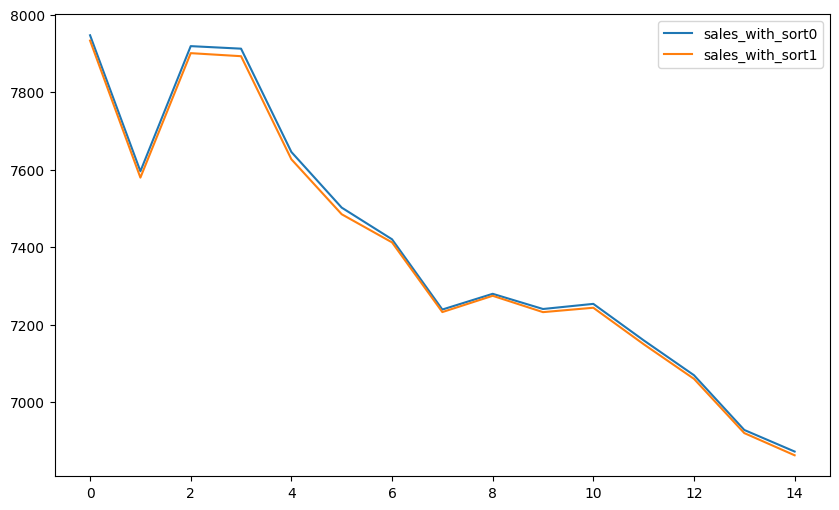

In [6]:
import matplotlib.pyplot as plt

compare_sales = list[dict]()
for d in date_range( start, end, datetime.timedelta(days=1)):
    sales = {}
    for s in range(sorts):
        result_df = pd.read_csv(f'../.data/ranking/{s}c-{d.strftime("%Y-%m-%d")}.csv')
        sales[f'sales_with_sort{s}'] = sum(result_df['predicted_purchase'])
    compare_sales.append(sales)
df = pd.DataFrame.from_records(compare_sales)
df.plot(figsize=(10, 6))